In [1]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import kagglehub
from kagglehub import KaggleDatasetAdapter
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score

d:\UNI FILES\term 8\eie3280\project\code\eie3280\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\UNI FILES\term 8\eie3280\project\code\eie3280\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<h3>Load the dataset</h3>

In [2]:

df = pd.read_csv('fake_reviews_dataset.csv')

df

print(df.columns)

Index(['category', 'rating', 'label', 'text_'], dtype='object')


<h3>Pre Processing - Cleanup the dataset</h3>

Download (run once)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [3]:


# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Apply stemming (optional, depends on your model needs)
    words = [stemmer.stem(word) for word in words]

    # Join words back into a string
    cleaned_text = " ".join(words)

    return cleaned_text

# Example usage: Clean the 'text' column in the DataFrame
# Apply the cleaning function to the 'text_' column
df['cleaned_review'] = df['text_'].apply(clean_text)

# Display the cleaned reviews alongside the original ones
print(df[['text_', 'cleaned_review']].head())



                                               text_  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                     cleaned_review  
0  love well made sturdi comfort love itveri pretti  
1      love great upgrad origin ive mine coupl year  
2            pillow save back love look feel pillow  
3               miss inform use great product price  
4               nice set good qualiti set two month  


<h3>Feature Engineering</h3>
Contains:
1. Review Length
2. Sentiment Polarity
3. Sentiment Subjectivity
4. ! Count
5. ? Count (maybe remove)
6. All-Caps word count
7. Superlative word count
8. Unique-word ratio
9. Rating score
10. Category one-hot encoding

In [7]:
print(df.columns.tolist())

['category', 'rating', 'label', 'text_', 'cleaned_review']


NOTE: Removed the ! and ? count as it is not an important feature and it is sparse (not found in all user reviews)

In [4]:
import pandas as pd
from textblob import TextBlob

# assume df is already loaded and has columns: 
#   'text_' (raw review), 'cleaned_review' (preprocessed text), 
#   'rating' (numeric), and 'category' (string)

# 1. Review length (number of words in the cleaned text)
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# 2. Sentiment polarity (range: -1 to +1)
df['sentiment_polarity'] = df['cleaned_review'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# 3. Sentiment subjectivity (range: 0 to 1)
df['sentiment_subjectivity'] = df['cleaned_review'].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

# 4. Exclamation mark count (from raw text)
# df['exclamation_count'] = df['text_'].apply(lambda x: x.count('!'))

# 5. Question mark count (from raw text)
# df['question_count'] = df['text_'].apply(lambda x: x.count('?'))

# 6. All‑CAPS word count (indicates “shouting” or emphasis)
df['allcaps_count'] = df['text_'].apply(
    lambda txt: sum(1 for w in txt.split() if w.isupper() and len(w) > 1)
)

# 7. Superlative words count
superlatives = ['best', 'worst', 'perfect', 'amazing', 
                'excellent', 'fantastic', 'unbelievable']
df['superlative_count'] = df['cleaned_review'].apply(
    lambda x: sum(1 for w in x.split() if w in superlatives)
)

# 8. Unique‑word ratio (lexical diversity)
df['unique_word_ratio'] = df['cleaned_review'].apply(
    lambda txt: len(set(txt.split())) / max(len(txt.split()), 1)
)

# 9. Rating score (use the star rating directly)
df['rating_score'] = df['rating'].astype(float)

# 10. Category one‑hot encoding
# At this point, df contains all engineered features alongside:
#  - 'cleaned_review' (for TF‑IDF vectorization)
#  - 'label'         (your target: real vs. fake)



In [9]:
print(df[['review_length',
          'sentiment_polarity',
          'sentiment_subjectivity',
          'allcaps_count',
          'superlative_count',
          'unique_word_ratio',
          'rating_score']].head())

   review_length  sentiment_polarity  sentiment_subjectivity  allcaps_count  \
0              8                0.50                   0.600              0   
1              8                0.65                   0.675              0   
2              7                0.25                   0.300              0   
3              6                0.80                   0.750              0   
4              7                0.65                   0.800              0   

   superlative_count  unique_word_ratio  rating_score  
0                  0           0.875000           5.0  
1                  0           1.000000           5.0  
2                  0           0.857143           5.0  
3                  0           1.000000           1.0  
4                  0           0.857143           5.0  


<h3>TF-IDF Vectorization of Cleand Review</h3>

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# 1) Vectorize text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3), stop_words='english')
X_text = tfidf.fit_transform(df['cleaned_review'])

# 2) Stack engineered features
numeric_cols = [
    'review_length','sentiment_polarity','sentiment_subjectivity',
    'allcaps_count','superlative_count',
    'unique_word_ratio','rating_score'
]
X_num = df[numeric_cols].values
X = hstack([X_text, X_num])
y = df['label'].values

# Map the string labels to numeric
df['y'] = df['label'].map({'OR': 0, 'CG': 1})

# Stack your features into X as before
X = hstack([X_text, X_num])

#Pull the numeric target
y = df['y'].values

#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


<h3>Cross Validation and Advanced Parameter Tuning in XGBoost</h3>
To get the best parameter

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score

# Cross-validation
cv_scores = cross_val_score(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                            X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f'Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Hyperparameter Tuning with Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    model = xgb.XGBClassifier(**param)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Create Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Accuracy:", study.best_value)


[I 2025-04-21 23:09:52,886] A new study created in memory with name: no-name-a8cc6cf9-aaef-4d15-b7c1-f0e4a3a3757a


Cross-validation accuracy: 0.8278 ± 0.0205


C:\Users\24bry\AppData\Local\Temp\ipykernel_20336\1521828398.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
C:\Users\24bry\AppData\Local\Temp\ipykernel_20336\1521828398.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\24bry\AppData\Local\Temp\ipykernel_20336\1521828398.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
[I 2025-04-21 23:10:34,020] T

Best Parameters: {'n_estimators': 459, 'learning_rate': 0.18553023284560893, 'max_depth': 7, 'subsample': 0.881496362923568, 'colsample_bytree': 0.6965242241037549}
Best Accuracy: 0.8902720527617477


<h4>Training with the best parameter</h4>

In [9]:
# Get the best parameters from the Optuna study
best_params = {'n_estimators': 459, 'learning_rate': 0.18553023284560893, 'max_depth': 7, 'subsample': 0.881496362923568, 'colsample_bytree': 0.6965242241037549}

# Initialize the XGBoost model with the best parameters
model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model on the full training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.4f}')

# Optionally, print the classification report and confusion matrix for detailed evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.8881
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6065
           1       0.89      0.88      0.89      6065

    accuracy                           0.89     12130
   macro avg       0.89      0.89      0.89     12130
weighted avg       0.89      0.89      0.89     12130

Confusion Matrix:
[[5421  644]
 [ 713 5352]]


<h3>To get the feature importance</h3>

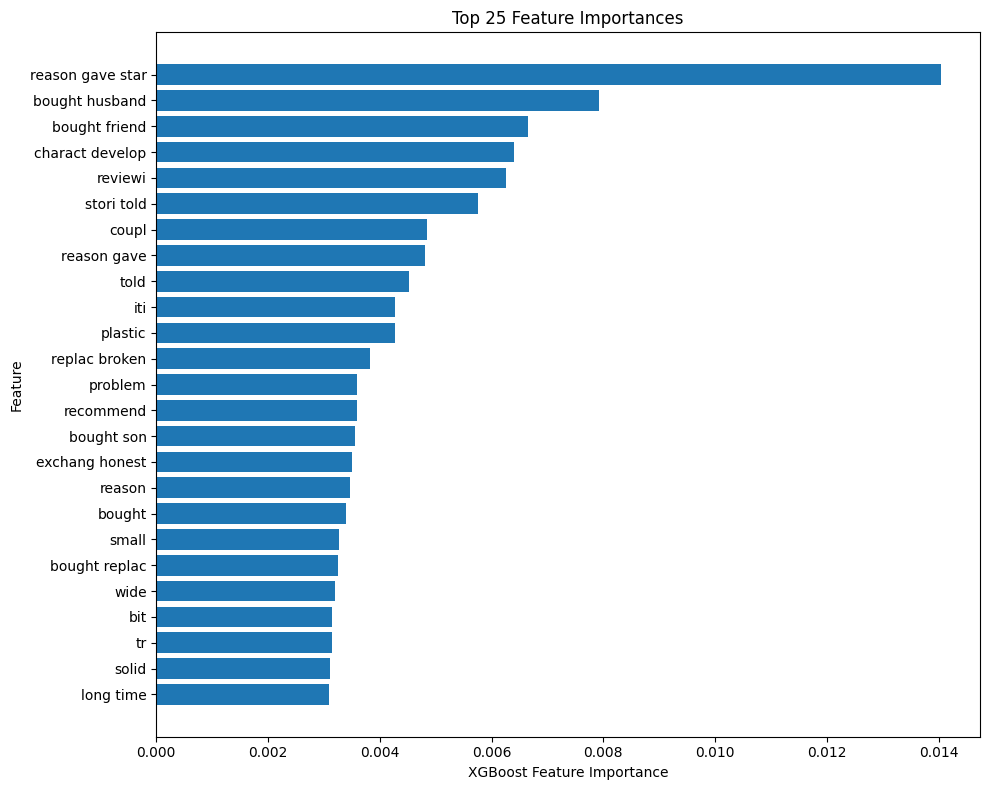

Top 25 features:
               feature  importance
3576  reason gave star    0.014040
521     bought husband    0.007928
513      bought friend    0.006645
685    charact develop    0.006405
3715           reviewi    0.006266
4242        stori told    0.005756
921              coupl    0.004851
3575       reason gave    0.004814
4503              told    0.004517
2226               iti    0.004271
3208           plastic    0.004267
3672     replac broken    0.003831
3342           problem    0.003596
3600         recommend    0.003586
532         bought son    0.003549
1409    exchang honest    0.003497
3573            reason    0.003462
507             bought    0.003400
4012             small    0.003274
525      bought replac    0.003245
4832              wide    0.003200
337                bit    0.003147
4535                tr    0.003147
4065             solid    0.003112
2538         long time    0.003085


In [ ]:
# Cell: Feature Importance Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Make sure pandas is imported

# 1. Get Feature Names
# TF-IDF feature names
tfidf_feature_names = tfidf.get_feature_names_out().tolist()

# Engineered numerical feature names (ensure this list matches the one used for stacking)
numeric_cols = [
    'review_length','sentiment_polarity','sentiment_subjectivity',
    'allcaps_count','superlative_count',
    'unique_word_ratio','rating_score'
]

# Combine all feature names in the correct order
all_feature_names = tfidf_feature_names + numeric_cols

# 2. Access Importance Scores from the trained model
importances = model.feature_importances_

# 3. Combine and Rank
# Create a DataFrame for easier handling
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 4. Visualize (Top N features)
n_top_features = 25 # You can adjust this number
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'][:n_top_features],
         feature_importance_df['importance'][:n_top_features])
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {n_top_features} Feature Importances')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

# Print the top N features and their scores
print(f"Top {n_top_features} features:")
print(feature_importance_df.head(n_top_features))

<h3>Using Random Forest</h3>

<h4>Hyper Parameter Tuning for Random Forest</h4>

In [ ]:
# Cell: Random Forest Hyperparameter Tuning with Optuna (Using Cross-Validation)

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # Import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np # Import numpy for mean calculation

# --- Prerequisites ---
# Ensure the following variables are defined and populated from your previous cells:
# X_train: Training features (sparse matrix)
# X_test: Testing features (sparse matrix)
# y_train: Training labels (numpy array)
# y_test: Testing labels (numpy array)
# --------------------

print("Starting Random Forest Hyperparameter Tuning (with Cross-Validation)...")

# 1. Define the objective function using Cross-Validation for Random Forest
def rf_objective_cv(trial):
    """Optuna objective function for Random Forest using cross-validation."""

    # Define hyperparameters to tune for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 400) # Number of trees
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True) # Max depth, log scale can be effective
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) # Min samples to split node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Min samples in a leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2']) # Features to consider for best split
    # Optional: you could also tune criterion or class_weight if imbalance is suspected
    # criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    # class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])

    # Create the RandomForestClassifier model with suggested parameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        # criterion=criterion,
        # class_weight=class_weight,
        random_state=42,  # Ensures reproducibility within the trial's CV
        n_jobs=-1         # Use all available CPU cores for training
    )

    # --- Evaluate using Cross-Validation on the TRAINING data ---
    # cv=3 is faster, cv=5 is potentially more robust but slower.
    # scoring='accuracy' defines the metric to optimize.
    try:
        scores = cross_val_score(
            rf_model,
            X_train,
            y_train,
            n_jobs=-1, # Use parallelism within cross_val_score if possible
            cv=3,      # Number of folds
            scoring='accuracy'
        )
        # Return the average accuracy across the folds
        accuracy = np.mean(scores)
    except Exception as e:
        print(f"Trial failed with parameters {trial.params}. Error: {e}")
        # Return a low value like 0.0 for failed trials to prevent Optuna from favoring them
        accuracy = 0.0

    return accuracy

# 2. Create an Optuna study object
# We want to find parameters that maximize the average cross-validation accuracy
rf_study_cv = optuna.create_study(direction="maximize")

# 3. Run the optimization process
# Adjust n_trials based on available time/compute resources. More trials explore more combinations.
n_trials_rf_cv = 50 # Example: 50 trials. Increase if possible.
print(f"Running Optuna optimization for {n_trials_rf_cv} trials...")
rf_study_cv.optimize(rf_objective_cv, n_trials=n_trials_rf_cv)

# 4. Report the best results found during tuning
print("\n--- Random Forest Tuning Results (Cross-Validation) ---")
print(f"Number of finished trials: {len(rf_study_cv.trials)}")
try:
    print("Best RF Parameters (CV):", rf_study_cv.best_params)
    # Note: This accuracy is the average score on the *training* data's CV folds
    print(f"Best CV Accuracy during tuning: {rf_study_cv.best_value:.4f}")
    best_rf_params_found = True
    best_rf_params_cv = rf_study_cv.best_params
except optuna.exceptions.OptunaError:
    print("Optimization finished without finding a best value (perhaps all trials failed).")
    best_rf_params_found = False

# 5. Train and evaluate the final Random Forest model using the best parameters
if best_rf_params_found:
    print("\nTraining final Random Forest model with best parameters found via CV...")

    # Initialize the final model using the best hyperparameters
    final_rf_model_cv = RandomForestClassifier(
        **best_rf_params_cv,  # Unpack the dictionary of best parameters
        random_state=42,    # Ensure final model is reproducible
        n_jobs=-1
    )

    # Train the final model on the *entire* training dataset
    final_rf_model_cv.fit(X_train, y_train)

    # --- Evaluate the final model on the UNSEEN test data ---
    print("Evaluating final model on the test set...")
    y_pred_final_rf_cv = final_rf_model_cv.predict(X_test)

    # Calculate and print final performance metrics
    final_rf_accuracy_cv = accuracy_score(y_test, y_pred_final_rf_cv)
    print(f'\nOptimized Random Forest Accuracy on test set (after CV tuning): {final_rf_accuracy_cv:.4f}')

    print("\nOptimized Random Forest Classification Report (CV):")
    # Use target_names consistent with your labels (0: Real/OR, 1: Fake/CG)
    print(classification_report(y_test, y_pred_final_rf_cv, target_names=['Real (OR)','Fake (CG)']))

    print("\nOptimized Random Forest Confusion Matrix (CV):")
    print(confusion_matrix(y_test, y_pred_final_rf_cv))
else:
    print("\nSkipping final model training as no best parameters were determined.")

[I 2025-04-26 03:28:09,201] A new study created in memory with name: no-name-a8218c14-d185-4eba-a178-db3bce7439b9


Starting Random Forest Hyperparameter Tuning (with Cross-Validation)...


[I 2025-04-26 03:28:13,089] Trial 0 finished with value: 0.8040774503568654 and parameters: {'n_estimators': 102, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.8040774503568654.
[I 2025-04-26 03:28:15,840] Trial 1 finished with value: 0.7862695215885803 and parameters: {'n_estimators': 298, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.8040774503568654.
[I 2025-04-26 03:28:18,561] Trial 2 finished with value: 0.7770828916684334 and parameters: {'n_estimators': 206, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8040774503568654.
[I 2025-04-26 03:28:20,550] Trial 3 finished with value: 0.7986714719807789 and parameters: {'n_estimators': 121, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.80407745035


--- Random Forest Tuning Results (CV) ---
Number of trials: 50
Best RF Parameters (CV): {'n_estimators': 174, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best CV Accuracy during tuning: 0.8335806656773372

Training final Random Forest model with best CV parameters...

Optimized Random Forest Accuracy on test set (after CV tuning): 0.8427

Optimized Random Forest Classification Report (CV):
              precision    recall  f1-score   support

   Real (OR)       0.83      0.87      0.85      6065
   Fake (CG)       0.86      0.82      0.84      6065

    accuracy                           0.84     12130
   macro avg       0.84      0.84      0.84     12130
weighted avg       0.84      0.84      0.84     12130


Optimized Random Forest Confusion Matrix (CV):
[[5254  811]
 [1097 4968]]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Initialize and train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 2) Predict on test set
y_pred = clf.predict(X_test)

# 3) Evaluate
print(classification_report(y_test, y_pred, target_names=['Real (OR)','Fake (CG)']))

# Optional: view confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

              precision    recall  f1-score   support

   Real (OR)       0.86      0.88      0.87      6065
   Fake (CG)       0.88      0.85      0.86      6065

    accuracy                           0.87     12130
   macro avg       0.87      0.87      0.87     12130
weighted avg       0.87      0.87      0.87     12130

Confusion matrix:
 [[5354  711]
 [ 901 5164]]


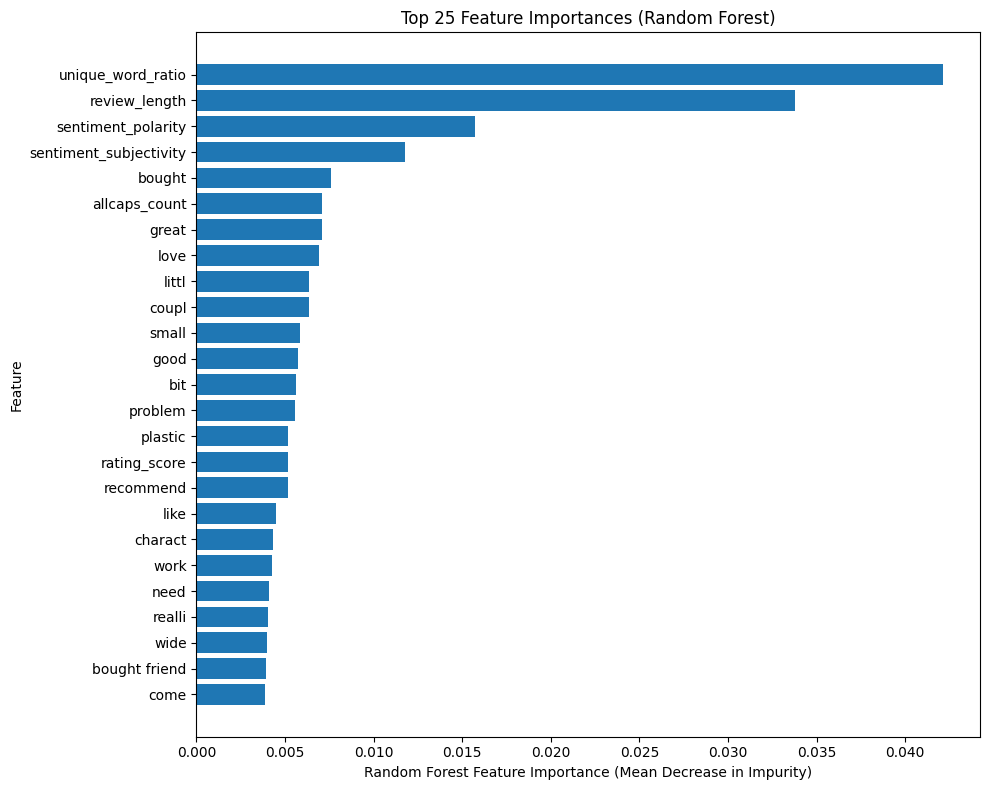

Top 25 features (Random Forest):
                     feature  importance
5005       unique_word_ratio    0.042112
5000           review_length    0.033783
5001      sentiment_polarity    0.015744
5002  sentiment_subjectivity    0.011753
507                   bought    0.007580
5003           allcaps_count    0.007112
1838                   great    0.007108
2592                    love    0.006905
2486                   littl    0.006373
921                    coupl    0.006341
4012                   small    0.005863
1738                    good    0.005732
337                      bit    0.005640
3342                 problem    0.005579
3208                 plastic    0.005189
5006            rating_score    0.005175
3600               recommend    0.005173
2418                    like    0.004501
679                  charact    0.004309
4880                    work    0.004279
2931                    need    0.004077
3543                  realli    0.004064
4832                    

In [17]:
# === Random Forest Feature Importance Analysis ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Make sure pandas is imported

# Ensure feature names are available (same as before)
# If you haven't run the XGBoost importance cell in the same session,
# you might need to redefine these:
# tfidf_feature_names = tfidf.get_feature_names_out().tolist()
# numeric_cols = [
#     'review_length','sentiment_polarity','sentiment_subjectivity',
#     'allcaps_count','superlative_count',
#     'unique_word_ratio','rating_score'
# ]
# all_feature_names = tfidf_feature_names + numeric_cols


# 1. Access Importance Scores from the TRAINED Random Forest model (`clf`)
# Make sure 'clf' is your fitted RandomForestClassifier object
rf_importances = clf.feature_importances_

# 2. Combine and Rank
# Create a DataFrame
rf_feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_importances
})

# Sort by importance
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False)

# 3. Visualize (Top N features)
n_top_features = 25 # Adjust as needed
plt.figure(figsize=(10, 8))
plt.barh(rf_feature_importance_df['feature'][:n_top_features],
         rf_feature_importance_df['importance'][:n_top_features])
plt.xlabel('Random Forest Feature Importance (Mean Decrease in Impurity)')
plt.ylabel('Feature')
plt.title(f'Top {n_top_features} Feature Importances (Random Forest)')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

# Print the top N features and their scores
print(f"Top {n_top_features} features (Random Forest):")
print(rf_feature_importance_df.head(n_top_features))

# 4. Check Importance of Engineered Features explicitly
print("\nImportance of Engineered Features (Random Forest):")
print(rf_feature_importance_df[rf_feature_importance_df['feature'].isin(numeric_cols)])

<h3>Logistic Regression</h3>

In [7]:
# Cell: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1) Initialize and train
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)

# 2) Predict on test set
y_pred_lr = lr.predict(X_test)

# 3) Evaluate
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['Real (OR)','Fake (CG)']))
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion matrix:\n", cm_lr)


=== Logistic Regression ===
              precision    recall  f1-score   support

   Real (OR)       0.86      0.86      0.86      6065
   Fake (CG)       0.86      0.85      0.86      6065

    accuracy                           0.86     12130
   macro avg       0.86      0.86      0.86     12130
weighted avg       0.86      0.86      0.86     12130

Confusion matrix:
 [[5195  870]
 [ 880 5185]]


<h3>SVM</h3>

In [ ]:
# Cell: Support Vector Machine (linear kernel)
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# 1) Initialize and train
svc = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
svc.fit(X_train, y_train)

# 2) Predict on test set
y_pred_svc = svc.predict(X_test)

# 3) Evaluate
print("=== SVM (Linear Kernel) ===")
print(classification_report(y_test, y_pred_svc, target_names=['Real (OR)','Fake (CG)']))
cm_svc = confusion_matrix(y_test, y_pred_svc)
print("Confusion matrix:\n", cm_svc)


NameError: name 'X_train' is not defined

: 

<h3>XGB Boost</h3>

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from tqdm import tqdm

# Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'max_depth': [3, 6, 10],
#     'subsample': [0.6, 0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# For RandomizedSearchCV,
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

tqdm.pandas()

# GridSearch
# xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                            #    param_grid, cv=2, scoring='accuracy', n_jobs=-1)
# xgb_grid_search.fit(X_train, y_train)


# RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                                       param_distributions=param_dist,
                                       n_iter=10,  # Number of random combinations to try
                                       cv=3,
                                       scoring='accuracy',
                                       n_jobs=-1)

xgb_random_search.fit(X_train, y_train)


print("Best Parameters:", xgb_random_search.best_params_)
print("Best Accuracy:", xgb_random_search.best_score_)


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:15:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best Accuracy: 0.8632958801498128


In [10]:
# Cell: XGBoost Classifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# 1) Initialize and train
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
)
xgb_clf.fit(X_train, y_train)

# 2) Predict on test set
y_pred_xgb = xgb_clf.predict(X_test)

# 3) Evaluate
print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb, target_names=['Real (OR)','Fake (CG)']))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion matrix:\n", cm_xgb)


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:47:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

   Real (OR)       0.86      0.87      0.87      6065
   Fake (CG)       0.87      0.86      0.86      6065

    accuracy                           0.86     12130
   macro avg       0.86      0.86      0.86     12130
weighted avg       0.86      0.86      0.86     12130

Confusion matrix:
 [[5294  771]
 [ 871 5194]]
